<a href="https://colab.research.google.com/github/samarmanjeshwar/602-final-project/blob/master/603_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import import_ipynb
from data603 import SparkLauncher
import pandas as pd
import matplotlib.pyplot as plt


importing Jupyter notebook from /scratch/data603_fall2020/to03375/data603/SparkLauncher.ipynb


# Create HDFS object

In [ ]:
from data603 import HDFSLauncher
hdfs = HDFSLauncher.get_hdfs()

importing Jupyter notebook from /scratch/data603_fall2020/to03375/data603/HDFSLauncher.ipynb


# Create spark config and start spark session

In [ ]:
# import the jupyter notebook importer
import import_ipynb
from data603 import SparkLauncher
from data603 import HDFSLauncher

# get a configuration object
conf = SparkLauncher.get_spark_conf()

# increase memory
conf.set('spark.executor.memory', '90g')
conf.set('spark.num.executors', 15)

# add a file to the configuration that will get copied to all the nodes on the cluster
conf.set('spark.yarn.dist.files', './keras_data/resnet50_weights_tf_dim_ordering_tf_kernels.h5')

# launch the cluster using the configuration
spark = SparkLauncher.get_spark_session(pack_venv = True, conf = conf)

import pandas as pd
import matplotlib.pyplot as plt

to03375
Packing Virtual Environment: /scratch/data603_admin/venv_cluster2 into to03375.tar.gz
Creating Spark Session: to03375_data603_spark_20201214_215556


# Read image, label, bbox data into separate spark dataframes

In [ ]:
bbox_df = spark.read.csv("/data/google_open_image/bboxes/*.csv",header=True)

In [ ]:
image_df = spark.read.parquet('/etl/google_open_image/images_updated.parquet')

In [ ]:
image_df.createTempView("image")

In [ ]:
label_df = spark.read.csv("/data/google_open_image/labels/*.csv", header=True)

In [ ]:
labelText_df = spark.read.csv("/data/google_open_image/metadata/class-descriptions-boxable.csv").toDF("LabelName", "LabelText")

In [ ]:
labelId_df = spark.read.csv("/data/google_open_image/metadata/class-descriptions-boxable.csv").toDF("LabelName", "LabelText")

# Join label dataframe to imageId dataframe

In [ ]:
label_join_df = label_df.join(labelId_df, on="LabelName", how="INNER")

In [ ]:
label_join_df.createTempView("join_")

# Created a new dataframe to track and show distribution of labels in the dataset

In [ ]:
label_dist = spark.sql("SELECT LabelText, COUNT(LabelText)FROM join_ GROUP BY LabelText LIMIT 50").toPandas()

In [ ]:
label_dist.head()

,LabelText,count(LabelText)
0,Flower,143348
1,Drink,43263
2,Golf cart,729
3,Sword,801
4,Goldfish,982


In [ ]:
#label_dist = label_dist.sort(label_dist[1])
label_dist = label_dist.sort_values("count(LabelText)", ascending=False)

In [ ]:
label_dist.head()

,LabelText,count(LabelText)
0,Flower,143348
42,Human body,97750
9,Tire,62454
1,Drink,43263
18,Human leg,42008


In [ ]:
label_dist = label_dist.set_index(label_dist["LabelText"], drop=True)

In [ ]:
label_dist.shape

(50, 2)

In [ ]:
X = list(label_dist["LabelText"].values)
y = list(label_dist["count(LabelText)"].values)

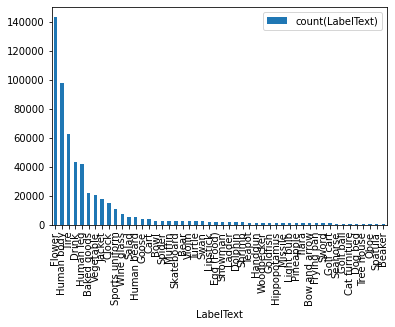

In [ ]:
ax = label_dist.plot(kind='bar')

# Plotted top 50 labels.  Flower had the most number of images

# Create dataframe for bounding box data

In [ ]:
bounding_boxes = spark.read.csv('/data/google_open_image/bboxes/*.csv',
                                header=True)

In [ ]:
bounding_boxes.createTempView("bbox")

# Find image IDs that would belong to potential data subsets

In [ ]:
snake_img_ids = spark.sql("SELECT ImageID FROM join_ WHERE LabelText='Snake'").collect()

In [ ]:
lizard_img_ids = spark.sql("SELECT ImageID FROM join_ WHERE LabelText='Lizard'").collect()

In [ ]:
dino_img_ids = spark.sql("SELECT ImageID FROM join_ WHERE LabelText='Dinosaur'").collect()

In [ ]:
croc_img_ids = spark.sql("SELECT ImageID FROM join_ WHERE LabelText='Crocodile'").collect()

# Create a method to extract a subset of data from the image dataframe based on the required imageIDs

In [ ]:
def get_data_subset(image_df, id_list):
    ids = []
    for img_id in id_list:
        ids.append(img_id[0])
    subset_df = image_df.where(image_df.ImageID.isin(ids))
    return subset_df

In [ ]:
snake_subset = get_data_subset(image_df, snake_img_ids)

In [ ]:
dino_subset = get_data_subset(image_df, dino_img_ids)

In [ ]:
croc_subset = get_data_subset(image_df, croc_img_ids)

In [ ]:
lizard_subset = get_data_subset(image_df, lizard_img_ids)

# Create similar subsets from the boundingbox dataset

In [ ]:
bbox_snake = get_data_subset(bounding_boxes, snake_img_ids)

In [ ]:
bbox_dino = get_data_subset(bounding_boxes, dino_img_ids)

In [ ]:
bbox_croc = get_data_subset(bounding_boxes, croc_img_ids)

In [ ]:
bbox_lizard = get_data_subset(bounding_boxes, lizard_img_ids)

# See which images have boundingboxes and which don't

In [ ]:
bbox_snake_img_ids = bbox_snake.select("ImageID").collect()
bbox_dino_img_ids = bbox_dino.select("ImageID").collect()
bbox_croc_img_ids = bbox_croc.select("ImageID").collect()
bbox_lizard_img_ids = bbox_lizard.select("ImageID").collect()

In [ ]:
def create_id_list(bbox_ids):
    ids = []
    for row in bbox_ids:
        ids.append(row[0])
    return ids

In [ ]:
bbox_snake_img_ids = create_id_list(bbox_snake_img_ids)
bbox_dino_img_ids = create_id_list(bbox_dino_img_ids)
bbox_croc_img_ids = create_id_list(bbox_croc_img_ids)
bbox_lizard_img_ids = create_id_list(bbox_lizard_img_ids)

In [ ]:
spark.sql("SELECT * FROM bbox WHERE ImageID = ''").show()

+-------+------+---------+----------+----+----+----+----+----------+-----------+---------+-----------+--------+
|ImageID|Source|LabelName|Confidence|XMin|XMax|YMin|YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|
+-------+------+---------+----------+----+----+----+----+----------+-----------+---------+-----------+--------+
+-------+------+---------+----------+----+----+----+----+----------+-----------+---------+-----------+--------+



# Can't proceed as all bounding box rows are associated with atleast one image

# Extract image chips from each subset of data

# Used method from HW3

In [ ]:
def extract_sub_image(data, xmin, xmax, ymin, ymax):
    print("extract function")
    from PIL import Image
    import io
    img = Image.open(io.BytesIO(data))
    (width, height) = img.size
    xmin = int(float(xmin) * width)
    xmax = int(float(xmax) * width)
    ymin = int(float(ymin) * height)
    ymax = int(float(ymax) * height)
    chip = img.crop(box = (xmin,ymin,xmax,ymax))
    buf = io.BytesIO()
    chip.save(buf, format = 'JPEG')
    print(type(buf))
    return buf.getvalue()

In [ ]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [ ]:
udf_extract_sub = F.udf(extract_sub_image, T.BinaryType())

# Create joined dataframes for image and bbox data for the subsets created above

In [ ]:
snake_subset_join = snake_subset.join(bbox_snake, on="ImageID", how="INNER")
dino_subset_join = dino_subset.join(bbox_dino, on="ImageID", how="INNER")
croc_subset_join = croc_subset.join(bbox_croc, on="ImageID", how="INNER")
lizard_subset_join = lizard_subset.join(bbox_lizard, on="ImageID", how="INNER")

In [ ]:
snake_subset_join.columns

['ImageID',
 'Format',
 'Data',
 'OriginalURL',
 'OriginalLandingURL',
 'License',
 'AuthorProfileURL',
 'Author',
 'Title',
 'OriginalSize',
 'OriginalMD5',
 'Thumbnail300KURL',
 'Rotation',
 'Subset',
 'Source',
 'LabelName',
 'Confidence',
 'XMin',
 'XMax',
 'YMin',
 'YMax',
 'IsOccluded',
 'IsTruncated',
 'IsGroupOf',
 'IsDepiction',
 'IsInside']

# Use udf to extract image chips

In [ ]:
snake_image_chips = snake_subset_join.withColumn("chipData", udf_extract_sub("Data", "XMin", "XMax", "YMin", "YMax"))
dino_image_chips = dino_subset_join.withColumn("chipData", udf_extract_sub("Data", "Xmin", "Xmax", "Ymin", "Ymax"))
croc_image_chips = croc_subset_join.withColumn("chipData", udf_extract_sub("Data", "Xmin", "Xmax", "Ymin", "Ymax"))
lizard_image_chips = lizard_subset_join.withColumn("chipData", udf_extract_sub("Data", "Xmin", "Xmax", "Ymin", "Ymax"))

In [ ]:
snake_image_chips.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- Format: string (nullable = true)
 |-- Data: binary (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: string (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: string (nullable = true)
 |-- XMin: string (nullable = true)
 |-- XMax: string (nullable = true)
 |-- YMin: string (nullable = true)
 |-- YMax: string (nullable = true)
 |-- IsOccluded: string (nullable = true)
 |-- IsTruncated: string (nullable = true)
 |-- IsGroupOf: string (nullable = true)
 |-- IsDepiction: strin

# Display one image from each subset (snake, dinosaur, crocodile, lizard)

In [ ]:
from PIL import Image
import io
def show_image(img_data):
    return Image.open(io.BytesIO(img_data))

In [ ]:
snake_df = snake_image_chips.select(["ImageID","LabelName","ChipData"])
snake_df = snake_df.toPandas()

In [ ]:
dino_df = dino_image_chips.select(["ImageID","LabelName","ChipData"])
dino_df = dino_df.toPandas()

In [ ]:
croc_df = croc_image_chips.select(["ImageID","LabelName","ChipData"])
croc_df = croc_df.toPandas()

In [ ]:
lizard_df = lizard_image_chips.select(["ImageID","LabelName","ChipData"])
lizard_df = lizard_df.toPandas()

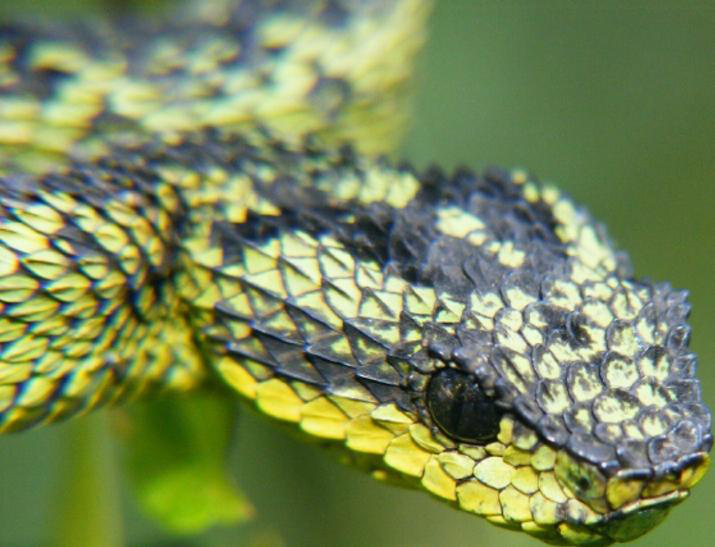

In [ ]:
show_image(snake_df.ChipData[7])

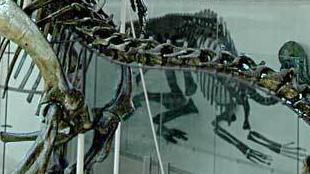

In [ ]:
show_image(dino_df.ChipData[900])

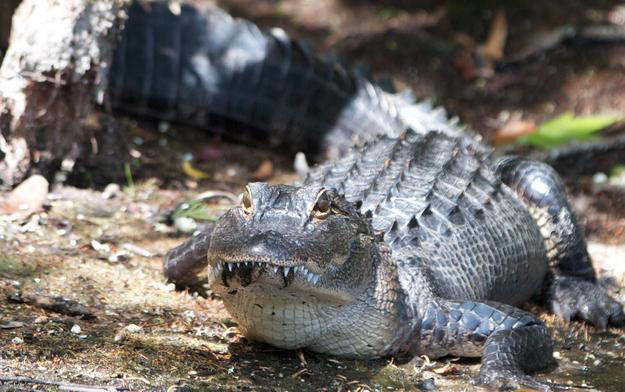

In [ ]:
show_image(croc_df.ChipData[800])

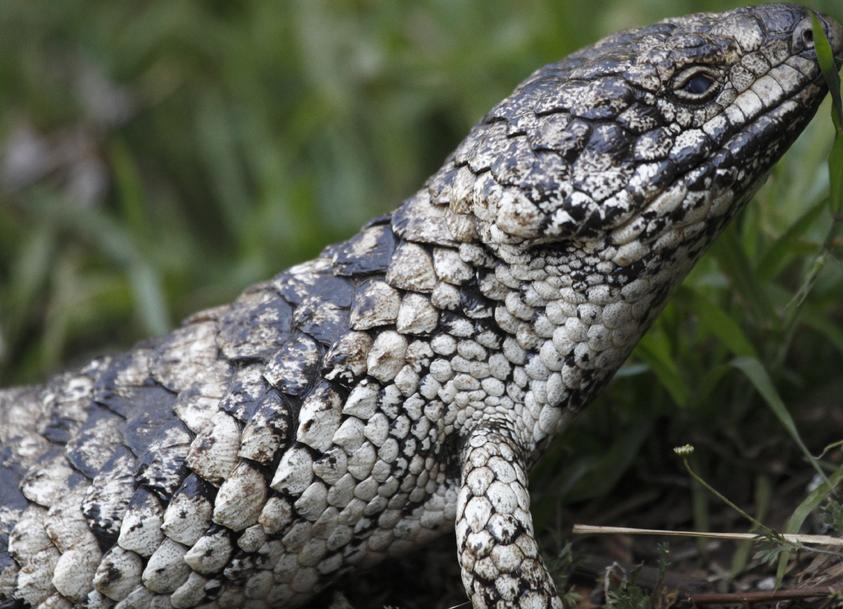

In [ ]:
show_image(lizard_df.ChipData[200])

# Note here that I had to search for image chips that were actually matching with their google label.  This is because the confidence of the incorrect labels was low.

# Create set-label for each data subset

In [ ]:
from pyspark.sql.functions import lit

snake_subset = snake_subset.withColumn("SetName", lit("snake"))
dino_subset = dino_subset.withColumn("SetName", lit("dino"))
croc_subset = croc_subset.withColumn("SetName", lit("croc"))
lizard_subset = lizard_subset.withColumn("SetName", lit("lizard"))

In [ ]:
snake_subset.printSchema()
snake_subset.count()

root
 |-- ImageID: string (nullable = true)
 |-- Format: string (nullable = true)
 |-- Data: binary (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: string (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- SetName: string (nullable = false)



2155

In [ ]:
dino_subset.printSchema()
dino_subset.count()

root
 |-- ImageID: string (nullable = true)
 |-- Format: string (nullable = true)
 |-- Data: binary (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: string (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- SetName: string (nullable = false)



1989

In [ ]:
croc_subset.printSchema()
croc_subset.count()

root
 |-- ImageID: string (nullable = true)
 |-- Format: string (nullable = true)
 |-- Data: binary (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: string (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- SetName: string (nullable = false)



1398

In [ ]:
lizard_subset.printSchema()
lizard_subset.count()

root
 |-- ImageID: string (nullable = true)
 |-- Format: string (nullable = true)
 |-- Data: binary (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: string (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- SetName: string (nullable = false)



3030

In [ ]:
lizard_subset.show(3)

+----------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+------------+--------------------+--------------------+--------+------+-------+
|         ImageID|Format|                Data|         OriginalURL|  OriginalLandingURL|             License|    AuthorProfileURL|         Author|               Title|OriginalSize|         OriginalMD5|    Thumbnail300KURL|Rotation|Subset|SetName|
+----------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+------------+--------------------+--------------------+--------+------+-------+
|005e6e7428da1db1|   JPG|[FF D8 FF E0 00 1...|https://farm2.sta...|https://www.flick...|https://creativec...|https://www.flick...|   Mr Thinktank|            DSCF3847|     1099806|BRjuFPb989rSBE6dy...|https://c4.static...|     0.0| train| lizard|
|00980117bd3

# Adding all subsets to iterable list (delete)

# Create udf to evaluate image data

In [ ]:
def evaluate_chip(chip_data):
    import io
    import os
    import tempfile
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input
    from keras.applications.resnet50 import decode_predictions
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array

    # STUPID HACK SHOULD PUT IN A BUG TO KERAS
    with tempfile.TemporaryDirectory(dir=f'{os.getcwd()}') as td:
        f_name = os.path.join(td, 'google_open_image_chip') # need to modify
        with open(f_name, 'wb') as fh:
            fh.write(chip_data) 
        #Load the image
        img = load_img(f_name, target_size = (224,224))
  
    # Prepare Image
    image = img_to_array(img)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Load Model Data
    model = ResNet50(weights = f'{os.getcwd()}/resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                 include_top = True)
    
    # Run prediction
    yhat = model.predict(image)

    # Decode Predictions
    label = decode_predictions(yhat)
    label = label[0][0]

    ret = {label[1]: float(label[2])}   

    return ret

In [ ]:
# make a UDF
from pyspark.sql.types import *
from pyspark.sql.functions import udf

schema = MapType(StringType(), DoubleType())

udf_evaluate_chip = udf(evaluate_chip, schema)

In [ ]:
snake_chip_data = snake_subset.withColumn("prediction", udf_evaluate_chip(snake_subset.Data))
dino_chip_data = dino_subset.withColumn("prediction", udf_evaluate_chip(dino_subset.Data))
croc_chip_data = croc_subset.withColumn("prediction", udf_evaluate_chip(croc_subset.Data))
lizard_chip_data = lizard_subset.withColumn("prediction", udf_evaluate_chip(lizard_subset.Data))

In [ ]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import map_keys
from pyspark.sql.functions import map_values
from pyspark.sql.functions import col

# Extract the prediction labels and confidence values from the returned map
snake_predictions = snake_chip_data.limit(6)  # otherwise this just doesn't work!
snake_predictions = snake_chip_data.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
dino_predictions = dino_chip_data.limit(6)
dino_predictions = dino_chip_data.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
croc_predictions = croc_chip_data.limit(6)
croc_predictions = croc_chip_data.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
lizard_predictions = lizard_chip_data.limit(6)
lizard_predictions = lizard_chip_data.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
snake_preds = snake_predictions.groupby('predicted_label').count().sort(col("count").desc())
dino_preds = dino_predictions.groupby('predicted_label').count().sort(col("count").desc())
croc_preds = croc_predictions.groupby('predicted_label').count().sort(col("count").desc())
lizard_preds = lizard_predictions.groupby('predicted_label').count().sort(col("count").desc())

In [ ]:
snake_preds.limit(5).toPandas()

,predicted_label,count
0,thunder_snake,123
1,night_snake,120
2,boa_constrictor,111
3,hognose_snake,107
4,garter_snake,103


In [ ]:
dino_preds.limit(5).toPandas()

,predicted_label,count
0,triceratops,579
1,fountain,45
2,common_iguana,37
3,book_jacket,36
4,Indian_elephant,32


In [ ]:
croc_preds.limit(5).toPandas()

,predicted_label,count
0,African_crocodile,328
1,American_alligator,322
2,common_iguana,45
3,Komodo_dragon,33
4,alligator_lizard,19


In [ ]:
lizard_preds.limit(5).toPandas()

,predicted_label,count
0,agama,326
1,common_iguana,299
2,green_lizard,205
3,alligator_lizard,159
4,American_chameleon,142


# From the analysis above, we find a lot of images that don't exactly fall under the specified category

# Let's do the same on chip data with confidence = 1

In [ ]:
lizard_image_chips.createTempView("lizard")

In [ ]:
lizard_image_chips_accurate = spark.sql("SELECT * FROM lizard WHERE Confidence = 1")

In [ ]:
dino_image_chips.createTempView("dino")

In [ ]:
dino_image_chips_accurate = spark.sql("SELECT * FROM dino WHERE Confidence = 1")

In [ ]:
croc_image_chips.createTempView("croc")

In [ ]:
croc_image_chips_accurate = spark.sql("SELECT * FROM croc WHERE Confidence = 1")

In [ ]:
snake_image_chips.createTempView("snake")

In [ ]:
snake_image_chips_accurate = spark.sql("SELECT * FROM snake WHERE Confidence = 1")

In [ ]:
snake_chip_data_accurate = snake_image_chips_accurate.withColumn("prediction", udf_evaluate_chip(snake_image_chips_accurate.chipData))
dino_chip_data_accurate = dino_image_chips_accurate.withColumn("prediction", udf_evaluate_chip(dino_image_chips_accurate.chipData))
croc_chip_data_accurate = croc_image_chips_accurate.withColumn("prediction", udf_evaluate_chip(croc_image_chips_accurate.chipData))
lizard_chip_data_accurate = lizard_image_chips_accurate.withColumn("prediction", udf_evaluate_chip(lizard_image_chips_accurate.chipData))

In [ ]:
snake_predictions_accu = snake_chip_data_accurate.limit(6)
snake_predictions_accu = snake_chip_data_accurate.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
dino_predictions_accu = dino_chip_data_accurate.limit(6)
dino_predictions_accu = dino_chip_data_accurate.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
croc_predictions_accu = croc_chip_data_accurate.limit(6)
croc_predictions_accu = croc_chip_data_accurate.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
lizard_predictions_accu = lizard_chip_data_accurate.limit(6)
lizard_predictions_accu = lizard_chip_data_accurate.select(explode(col("prediction")).alias("predicted_label", "predicted_score"))

In [ ]:
snake_preds_accu = snake_predictions_accu.groupby('predicted_label').count().sort(col("count").desc())
dino_preds_accu = dino_predictions_accu.groupby('predicted_label').count().sort(col("count").desc())
croc_preds_accu = croc_predictions_accu.groupby('predicted_label').count().sort(col("count").desc())
lizard_preds_accu = lizard_predictions_accu.groupby('predicted_label').count().sort(col("count").desc())

In [ ]:
snake_preds_accu.limit(5).toPandas()

,predicted_label,count
0,boa_constrictor,198
1,thunder_snake,151
2,night_snake,146
3,garter_snake,143
4,hognose_snake,134


In [ ]:
dino_preds_accu.limit(5).toPandas()

,predicted_label,count
0,triceratops,1276
1,window_screen,238
2,shower_curtain,157
3,lakeside,120
4,potter's_wheel,105


In [ ]:
croc_preds_accu.limit(5).toPandas()

,predicted_label,count
0,African_crocodile,407
1,American_alligator,345
2,shower_curtain,116
3,common_newt,79
4,triceratops,79


In [ ]:
lizard_preds_accu.limit(5).toPandas()

,predicted_label,count
0,common_iguana,438
1,agama,326
2,African_chameleon,236
3,green_lizard,234
4,common_newt,197


In [ ]:
spark.stop()